# Study Log
- 출처 : [Cifar100 with CNN from Scratch and GoogLeNet](https://www.kaggle.com/code/masrur007/cifar100-with-cnn-from-scratch-and-googlenet#Introduction)
- 220412 tue

# Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 결과 확인을 용이하게 하기 위한 코드
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

# Define dataloader and visualization

In [3]:
# define transformations for train
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=.30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# define transformations for test
# for test we dont need much of augmentations other than converting to tensors and normalizing the pictures
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
# ssl을 끄지 않으면 error가 뜸
# https://github.com/pytorch/vision/issues/5039
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_data = datasets.CIFAR10('./data', train = True, download = True, transform = train_transform)
test_data = datasets.CIFAR10('./data', train = False, download = True, transform = test_transform)

print(len(train_data))
print(len(test_data))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [5]:
# train, valid split
valid_size = 0.15

indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len(train_data)))

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# data loaders (combine dataset and sampler)
# Dataloader provides an iterable over the specified dataset by combining a dataset with a sampler.
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
# function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image

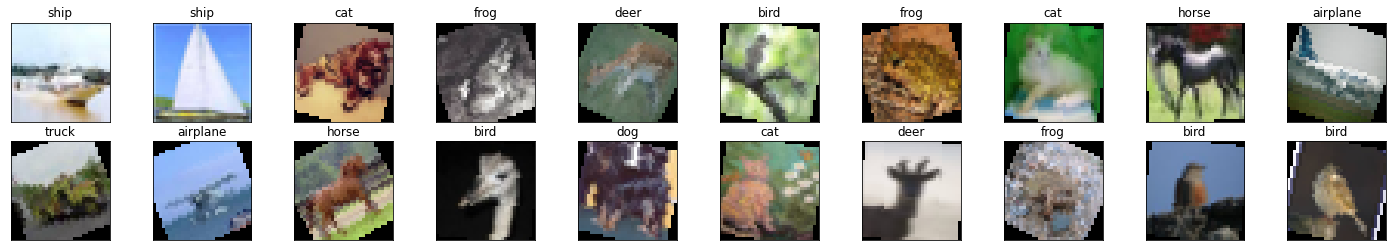

In [8]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    _ = ax.set_title(classes[labels[idx]])

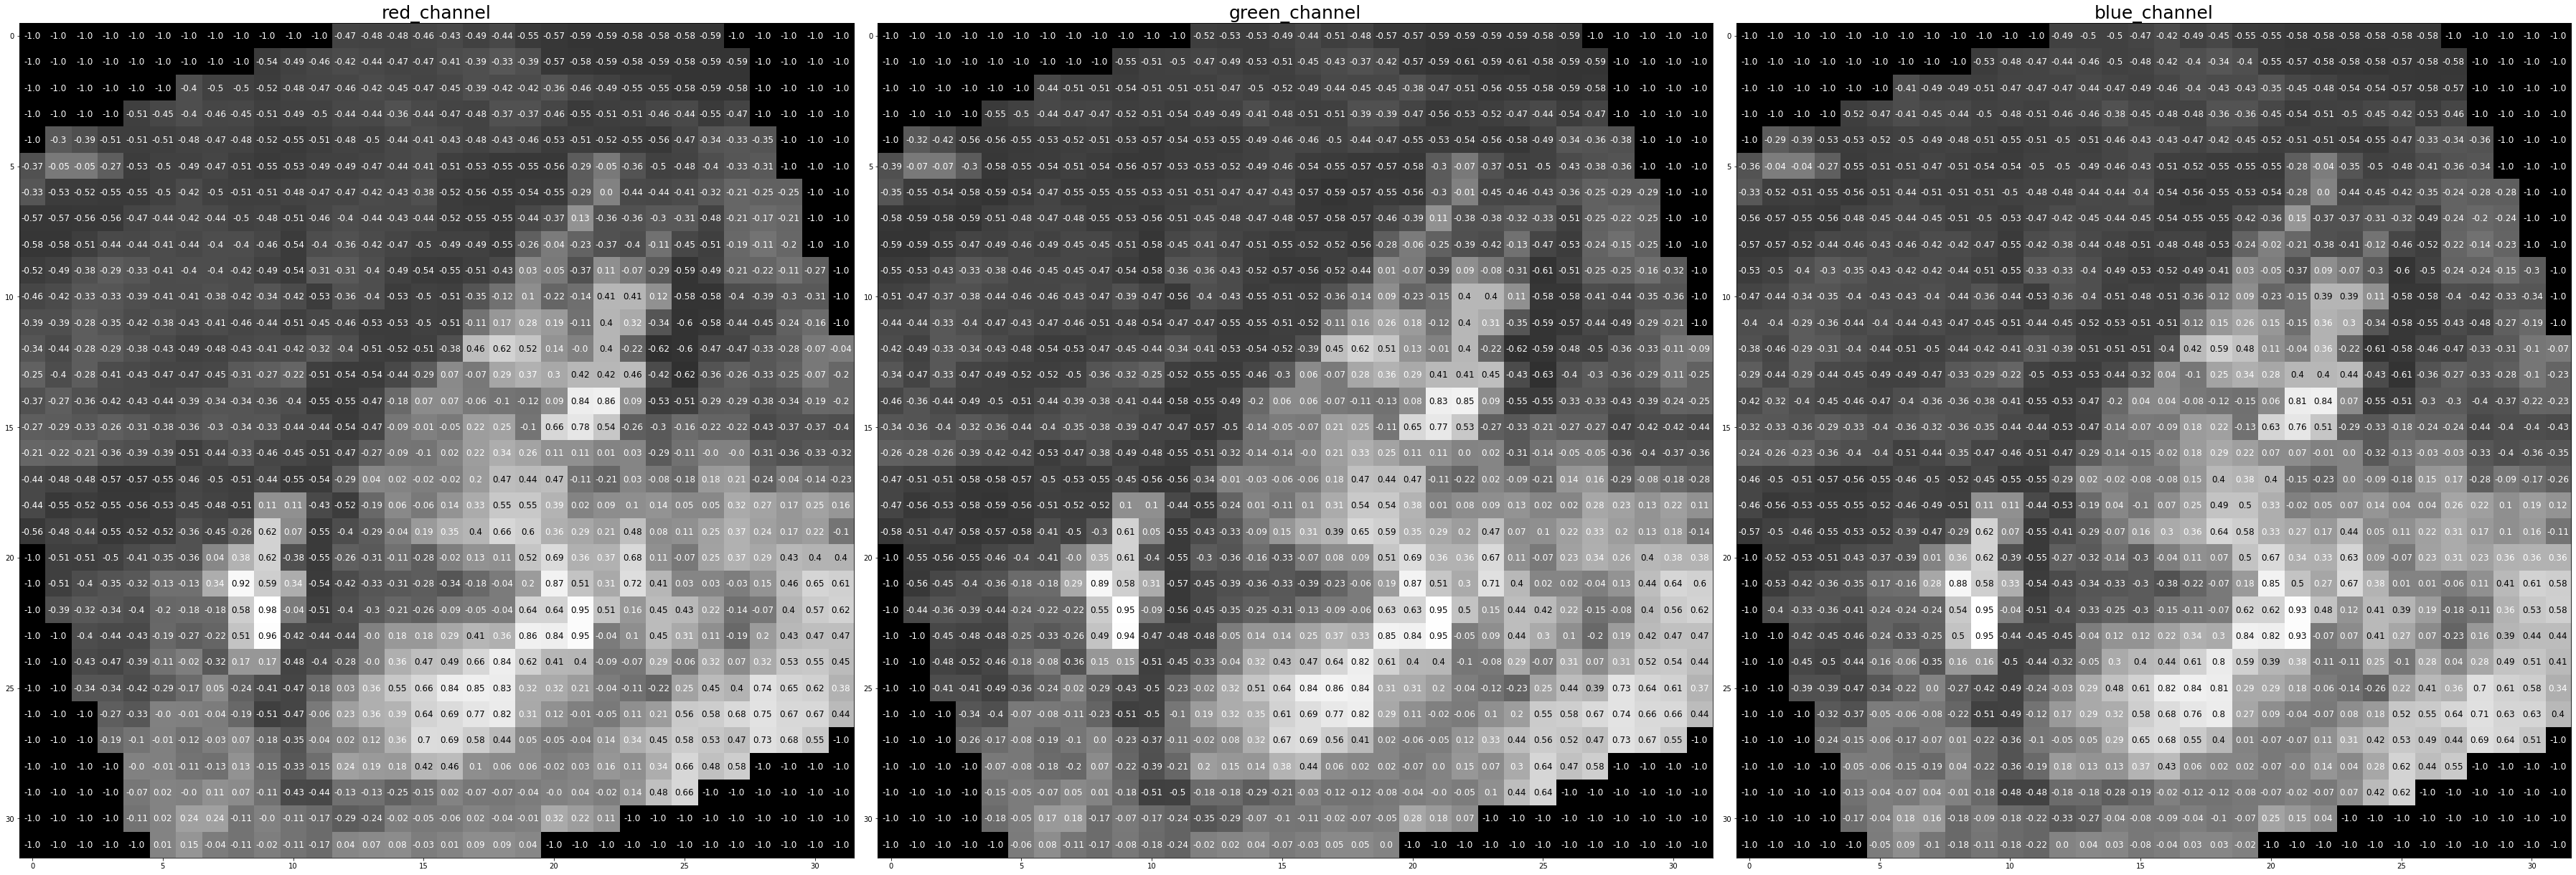

In [9]:
# let's look into details of normalized RGB

# np.squeeze() : 크기가 1인 추가 axis를 제거해줌 ex. [[1, 2]] -> [1, 2] 
rgb_img = np.squeeze(images[3]) # rgb_img.shape = (3, 32, 32)
channels = ['red_channel', 'green_channel', 'blue_channel']

fig = plt.figure(figsize = (50, 50))
for idx in np.arange(rgb_img.shape[0]): # 3
    
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    _ = ax.imshow(img, cmap='gray')
    _ = ax.set_title(channels[idx],size=25)
    
    width, height = img.shape # 32, 32
    thresh = img.max()/2.5 # 왜 2.5로 나눔? 이 값은 고정된 기준 값인가?
    
    for x in range(width): 
        for y in range(height):
            
            # img(32, 32)내의 픽셀값을 소수점 둘째자리까지 반올림 해주기 
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            _ = ax.annotate(str(val), xy=(y,x), horizontalalignment='center',
                       verticalalignment='center', size=12, color='white'
                       if img[x][y]<thresh else 'black')
plt.tight_layout()

# Create a CNN to Classify (from Scratch)

In [10]:
# check if CUDA is available 
if torch.cuda.is_available():
    print('CUDA is available. Training on GPU ...')
else:
    print('CUDA is not available! Traning on CPU ...')

CUDA is not available! Traning on CPU ...


In [11]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer (sees 32 x 32 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 x 16 x 16
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 8 x 8 x 32
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2) 
        
        # linear layer (64 x 4 x 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10) # 500 -> 10
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input
        x = x.view(-1, 64 * 4 * 4) # fc layer에 들어가기 전 shape이 (64, 4, 4)
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 1st hidden layer with relu activation function
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 2nd hidden layer with relu activation function
        x = self.fc2(x)
        
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [12]:
#let's see the model
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 500]         512,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.06
Estimated T

## Train the model

In [15]:
# output.shape = [32, 10] / target.shape = [32]

# batch_size = 32이므로 32개마다의 corrects 개수 계산
for data, target in train_loader:
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    corrects = pred.eq(target.view_as(pred)).sum().item()
    print(corrects)
    break

4


In [18]:
'''
⭐️ valid dataset의 개수 구할 때 주의
'''

# 방법 1
print(len(valid_sampler))

# 방법 2
print(len(valid_loader.sampler))

# 틀린 방법
# valid_loader의 dataset은 train_data이기 때문에 train_data.shape을 return함
valid_len2 = len(valid_loader.dataset) 
print(valid_len2)

7500
7500
50000


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

n_epochs = 10
valid_loss_min = np.Inf

'''
< accuracy 추가 시 사용하는 코드 >
sum_correct = 0

output = model_transfer(data)
pred = output.argmax(dim=1, keepdim=True) 
corrects = pred.eq(target.view_as(pred)).sum().item()

sum_correct += corrects
accuracy = sum_correct / len(valid_loader.sampler) * 100
'''

for epoch in range(1, n_epochs+1):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # --------------- #
    # train the model #
    # --------------- #
    model.train()
    for data, target in train_loader:
        
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass : compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass : compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)

    # ------------------ #
    # validate the model #
    # ------------------ #
    sum_correct = 0
    
    model.eval()
    for data, target in valid_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        
        # accuracy 
        pred = output.argmax(dim=1, keepdim=True) 
        corrects = pred.eq(target.view_as(pred)).sum().item()
        sum_correct += corrects
        
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    
    # calculate average losses & average accuracy
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    accuracy = sum_correct / len(valid_loader.sampler) * 100
    
    print(f'Epoch {epoch}/{n_epochs} \t train_loss: {train_loss:.3f} \t val_loss: {valid_loss:.3f} \t accuracy: {accuracy:.3f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('val_loss decreased [ {:.3f} --> {:.3f} | diff: {:.3f} ] Saving model...'.format(valid_loss_min, valid_loss, valid_loss_min-valid_loss))
        print('------------------')
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch 1/10 	 train_loss: 2.191 	 val_loss: 2.042 	 accuracy: 23.787
val_loss decreased [ inf --> 2.042 | diff: inf ] Saving model...
------------------
Epoch 2/10 	 train_loss: 1.935 	 val_loss: 1.875 	 accuracy: 31.307
val_loss decreased [ 2.042 --> 1.875 | diff: 0.167 ] Saving model...
------------------


# Create a CNN to Classify (using Transfer Learning)

In [ ]:
model_transfer = models.googlenet(pretrained = True)
# print(model_transfer)

for param in model_transfer.parameters():
    param.requires_grad = False

# replace the last fully connected layer with a Linear layer 133 output
in_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(in_features, 10) # in_features = 1024

if torch.cuda.is_available():
    model_transfer = model_transfer.cuda()
    
# summary(model_transfer, input_size=(3, 32, 32))

In [ ]:
criterion = nn.CrossEntropyLoss()

'''
< accuracy 추가 시 사용하는 코드 >
sum_correct = 0

output = model_transfer(data)
pred = output.argmax(dim=1, keepdim=True) 
corrects = pred.eq(target.view_as(pred)).sum().item()
sum_correct += corrects

accuracy = sum_correct / len(valid_loader.sampler) * 100
'''

# filter(함수, 리스트) : 리스트에 들어있는 원소들을 함수에 적용시켜서 결과가 참인 값들로 새로운 리스트 생성 
# model_transfer의 parameter 중에서 grad의 변화도를 갖는 parameter만 가진 리스트 생성
model_transfer_grad_parameters = filter(lambda p: p.requires_grad, model_transfer.parameters())
optimizer = torch.optim.Adam(model_transfer_grad_parameters, lr=0.001)

n_epochs = 10
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    # --------------- #
    # train the model #
    # --------------- #
    model_transfer.train()
    for data, target in train_loader: # target.shape = [32]

#         if torch.cuda.is_available():
#             data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad() # train only
        output = model_transfer(data) # output.shape = [32, 10]
        loss = criterion(output, target)
        loss.backward() # train only
        optimizer.step() # train only
        train_loss += loss.item()*data.size(0)
    
    # ------------------ #
    # validate the model #
    # ------------------ #
    model_transfer.eval()
    sum_correct = 0
    for data, target in valid_loader:
#         if torch.cuda.is_available():
#             data, target = data.cuda(), target.cuda()
        
        output = model_transfer(data)
        
        # accuracy
        pred = output.argmax(dim=1, keepdim=True) 
        corrects = pred.eq(target.view_as(pred)).sum().item()
        sum_correct += corrects
        
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    accuracy = sum_correct / len(valid_loader.sampler) * 100

    print(f'Epoch {epoch}/{n_epochs} \t train_loss: {train_loss:.3f} \t val_loss: {valid_loss:.3f} \t accuracy: {accuracy:.3f}')
    print('------------------')
    
    if valid_loss <= valid_loss_min:
        print('val_loss decreased [ {:.3f} --> {:.3f} | diff: {:.3f} ] Saving model...'.format(valid_loss_min, valid_loss, valid_loss_min-valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer_cifar.pt')
        valid_loss_min = valid_loss

# Test